In [55]:
# Define input and output file paths
#input_path = "/content/a1.csv"
#output_path = "/content/a1_cleaned.csv"

# Open original file and cleaned output file
#with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
#    for line in infile:
        # Remove trailing comma (and whitespace) and write to new file
#        cleaned_line = line.rstrip(',\n') + '\n'
#        outfile.write(cleaned_line)

#print(f"Trailing commas removed. Cleaned file saved to: {output_path}")

Trailing commas removed. Cleaned file saved to: /content/a1_cleaned.csv


In [1]:
from google.colab import files
import zipfile

# Upload your zip file containing all 12 CSVs
uploaded = files.upload()

# If uploaded as a zip, unzip it
with zipfile.ZipFile('projectdataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


Saving projectdataset.zip to projectdataset.zip


In [2]:
import os
import pandas as pd

folder_path = '/content/projectdataset'  # Folder where CSVs are extracted
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

data_by_condition = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    data_by_condition[file] = df  # key = filename = condition

data_by_condition['4mm420_cleaned.csv'].head()



Time (s)  X-Axis (m/s2)  Y- Axis (m/s2)  Z-Axis (m/s2)
0  0.000000       0.033374       -0.032450      -0.046653
1  0.002456      -0.026900        0.014239      -0.031580
2  0.004913      -0.015777        0.003734      -0.027178
3  0.007369      -0.081535        0.008730       0.058657
4  0.009826       0.080256       -0.104043      -0.025816

In [3]:
import os
import pandas as pd
import numpy as np

folder_path = '/content/projectdataset'  # Adjust if needed
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

all_windows = []  # List to hold all segmented windows from all files

for file_name in csv_files:
    # Load data
    df = pd.read_csv(os.path.join(folder_path, file_name))

    # Clean column names if needed (optional)
    df.columns = df.columns.str.strip()  # in case of extra spaces like ' X'

    # Check if necessary columns exist
    if not all(col in df.columns for col in ['Time (s)', 'X-Axis (m/s2)', 'Y- Axis (m/s2)', 'Z-Axis (m/s2)']):
        print(f"Skipping {file_name}: missing required columns.")
        continue

    # Estimate sampling rate
    time_diffs = np.diff(df['Time (s)'])
    median_diff = np.median(time_diffs)
    if median_diff == 0:
        print(f"Skipping {file_name}: zero time difference.")
        continue

    sampling_rate = int(round(1 / median_diff))
    samples_per_window = sampling_rate
    num_windows = len(df) // samples_per_window

    for i in range(num_windows):
        start = i * samples_per_window
        end = start + samples_per_window

        segment = {
            'file': file_name,
            'start_time': df['Time (s)'].iloc[start],
            'X': df['X-Axis (m/s2)'].iloc[start:end].values,
            'Y': df['Y- Axis (m/s2)'].iloc[start:end].values,
            'Z': df['Z-Axis (m/s2)'].iloc[start:end].values,
            'sampling_rate': sampling_rate
        }
        all_windows.append(segment)

# Convert to DataFrame
windows_df = pd.DataFrame(all_windows)

# Preview result
print(windows_df.head())
print("Total 1-second windows extracted:", len(windows_df))


                 file  start_time  \
0  4mm550_cleaned.csv    0.000000   
1  4mm550_cleaned.csv    0.999747   
2  4mm550_cleaned.csv    1.999496   
3  4mm550_cleaned.csv    2.999245   
4  4mm550_cleaned.csv    3.998994   

                                                   X  \
0  [-0.1685078376817103, -0.1214064665069099, 0.2...   
1  [-0.0155334268842576, 0.0947717174025823, -0.0...   
2  [0.0278740653839182, 0.0490988655445156, -0.04...   
3  [0.1028509899988057, -0.1053165066230868, -0.0...   
4  [0.0705177708107767, 0.0487571849337051, 0.037...   

                                                   Y  \
0  [-0.0529642197033112, 0.1318261073000951, -0.1...   
1  [0.1331001193567689, -0.1978869371617177, 0.11...   
2  [-0.1045211510510332, 0.0120959912418455, 0.06...   
3  [-0.1589595619241827, 0.2001704976240448, 0.03...   
4  [-0.2744401612876466, 0.1345856283904226, -0.0...   

                                                   Z  sampling_rate  
0  [-0.0070581909301541, -0.00756

In [4]:
windows_df['sampling_rate'].unique()


array([407])

In [5]:
# Max frequency that FFT can resolve = Nyquist frequency = sampling_rate / 2
print("Max possible frequency in FFTs:")
for sr in windows_df['sampling_rate'].unique():
    print(f"Sampling Rate: {sr} Hz → Max Frequency: {sr/2:.1f} Hz")


Max possible frequency in FFTs:
Sampling Rate: 407 Hz → Max Frequency: 203.5 Hz


In [7]:
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from scipy.stats import kurtosis
import numpy as np

def extract_all_fft_features(signal, sampling_rate):
    N = len(signal)
    freqs = rfftfreq(N, d=1/sampling_rate)
    fft_vals = np.abs(rfft(signal))

    total_energy = np.sum(fft_vals**2)

    # Band energy (adjusted)
    band_mask = (freqs >= 50) & (freqs <= 200)
    band_energy = np.sum(fft_vals[band_mask]**2)
    band_energy_ratio = band_energy / total_energy if total_energy > 0 else 0

    # Dominant frequency
    dominant_freq = freqs[np.argmax(fft_vals)]

    # Spectral centroid
    spectral_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals) if np.sum(fft_vals) > 0 else 0

    # Peak count
    peaks, _ = find_peaks(fft_vals, height=0.1 * np.max(fft_vals))
    peak_count = len(peaks)

    # Spectral kurtosis
    spectral_kurtosis = kurtosis(fft_vals)

    return band_energy_ratio, dominant_freq, spectral_centroid, peak_count, spectral_kurtosis

fft_features = []

for _, row in windows_df.iterrows():
    for axis in ['X', 'Y', 'Z']:
        signal = row[axis]
        sr = row['sampling_rate']

        ber, dom_freq, centroid, peaks, kurt = extract_all_fft_features(signal, sr)

        fft_features.append({
            'file': row['file'],
            'start_time': row['start_time'],
            'axis': axis,
            'band_energy_ratio': ber,
            'dominant_freq': dom_freq,
            'spectral_centroid': centroid,
            'peak_count': peaks,
            'spectral_kurtosis': kurt
        })

features_df = pd.DataFrame(fft_features)
features_df.head()

file  start_time axis  band_energy_ratio  dominant_freq  \
0  4mm550_cleaned.csv    0.000000    X           0.975974          128.0   
1  4mm550_cleaned.csv    0.000000    Y           0.853921          202.0   
2  4mm550_cleaned.csv    0.000000    Z           0.978953          100.0   
3  4mm550_cleaned.csv    0.999747    X           0.986927          117.0   
4  4mm550_cleaned.csv    0.999747    Y           0.944174          158.0   

   spectral_centroid  peak_count  spectral_kurtosis  
0         112.316591          35          20.020321  
1         137.665749          56           1.541359  
2         119.045641          51           8.203122  
3         112.510180          36           9.531910  
4         138.322679          45           4.111524

In [10]:
from scipy.stats import skew

def extract_time_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    std = np.std(signal)
    max_val = np.max(signal)
    min_val = np.min(signal)
    peak_to_peak = max_val - min_val
    signal_skew = skew(signal)
    signal_kurtosis = kurtosis(signal)

    return rms, std, peak_to_peak, signal_skew, signal_kurtosis


In [12]:
combined_features = []

for _, row in windows_df.iterrows():
    for axis in ['X', 'Y', 'Z']:
        signal = row[axis]
        sr = row['sampling_rate']

        # Time-domain
        rms, std, p2p, s_skew, s_kurt = extract_time_features(signal)

        # Frequency-domain
        ber, dom_freq, centroid, peaks, f_kurt = extract_all_fft_features(signal, sr)

        combined_features.append({
            'file': row['file'],
            'start_time': row['start_time'],
            'axis': axis,
            # Time features
            'rms': rms,
            'std': std,
            'peak_to_peak': p2p,
            'time_skew': s_skew,
            'time_kurtosis': s_kurt,
            # FFT features
            'band_energy_ratio': ber,
            'dominant_freq': dom_freq,
            'spectral_centroid': centroid,
            'peak_count': peaks,
            'spectral_kurtosis': f_kurt
        })

combined_df = pd.DataFrame(combined_features)
combined_df.head()

file  start_time axis       rms       std  peak_to_peak  \
0  4mm550_cleaned.csv    0.000000    X  0.099453  0.099452      0.577610   
1  4mm550_cleaned.csv    0.000000    Y  0.138011  0.138011      0.822975   
2  4mm550_cleaned.csv    0.000000    Z  0.070739  0.070739      0.388404   
3  4mm550_cleaned.csv    0.999747    X  0.095398  0.095398      0.543608   
4  4mm550_cleaned.csv    0.999747    Y  0.135585  0.135585      0.755706   

   time_skew  time_kurtosis  band_energy_ratio  dominant_freq  \
0  -0.030359      -0.194125           0.975974          128.0   
1  -0.048141       0.331447           0.853921          202.0   
2  -0.005374      -0.258773           0.978953          100.0   
3  -0.039966      -0.228446           0.986927          117.0   
4  -0.066550      -0.111257           0.944174          158.0   

   spectral_centroid  peak_count  spectral_kurtosis  
0         112.316591          35          20.020321  
1         137.665749          56           1.541359  
2         119.045641          51           8.203122  
3         112.510180          36           9.531910  
4         138.322679          45           4.111524

In [13]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['rms', 'std', 'peak_to_peak', 'time_skew', 'time_kurtosis',
                'band_energy_ratio', 'dominant_freq', 'spectral_centroid', 'peak_count', 'spectral_kurtosis']

X_combined = combined_df[feature_cols]
scaler = StandardScaler()
X_scaled_combined = scaler.fit_transform(X_combined)


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
combined_df['cluster'] = kmeans.fit_predict(X_scaled_combined)


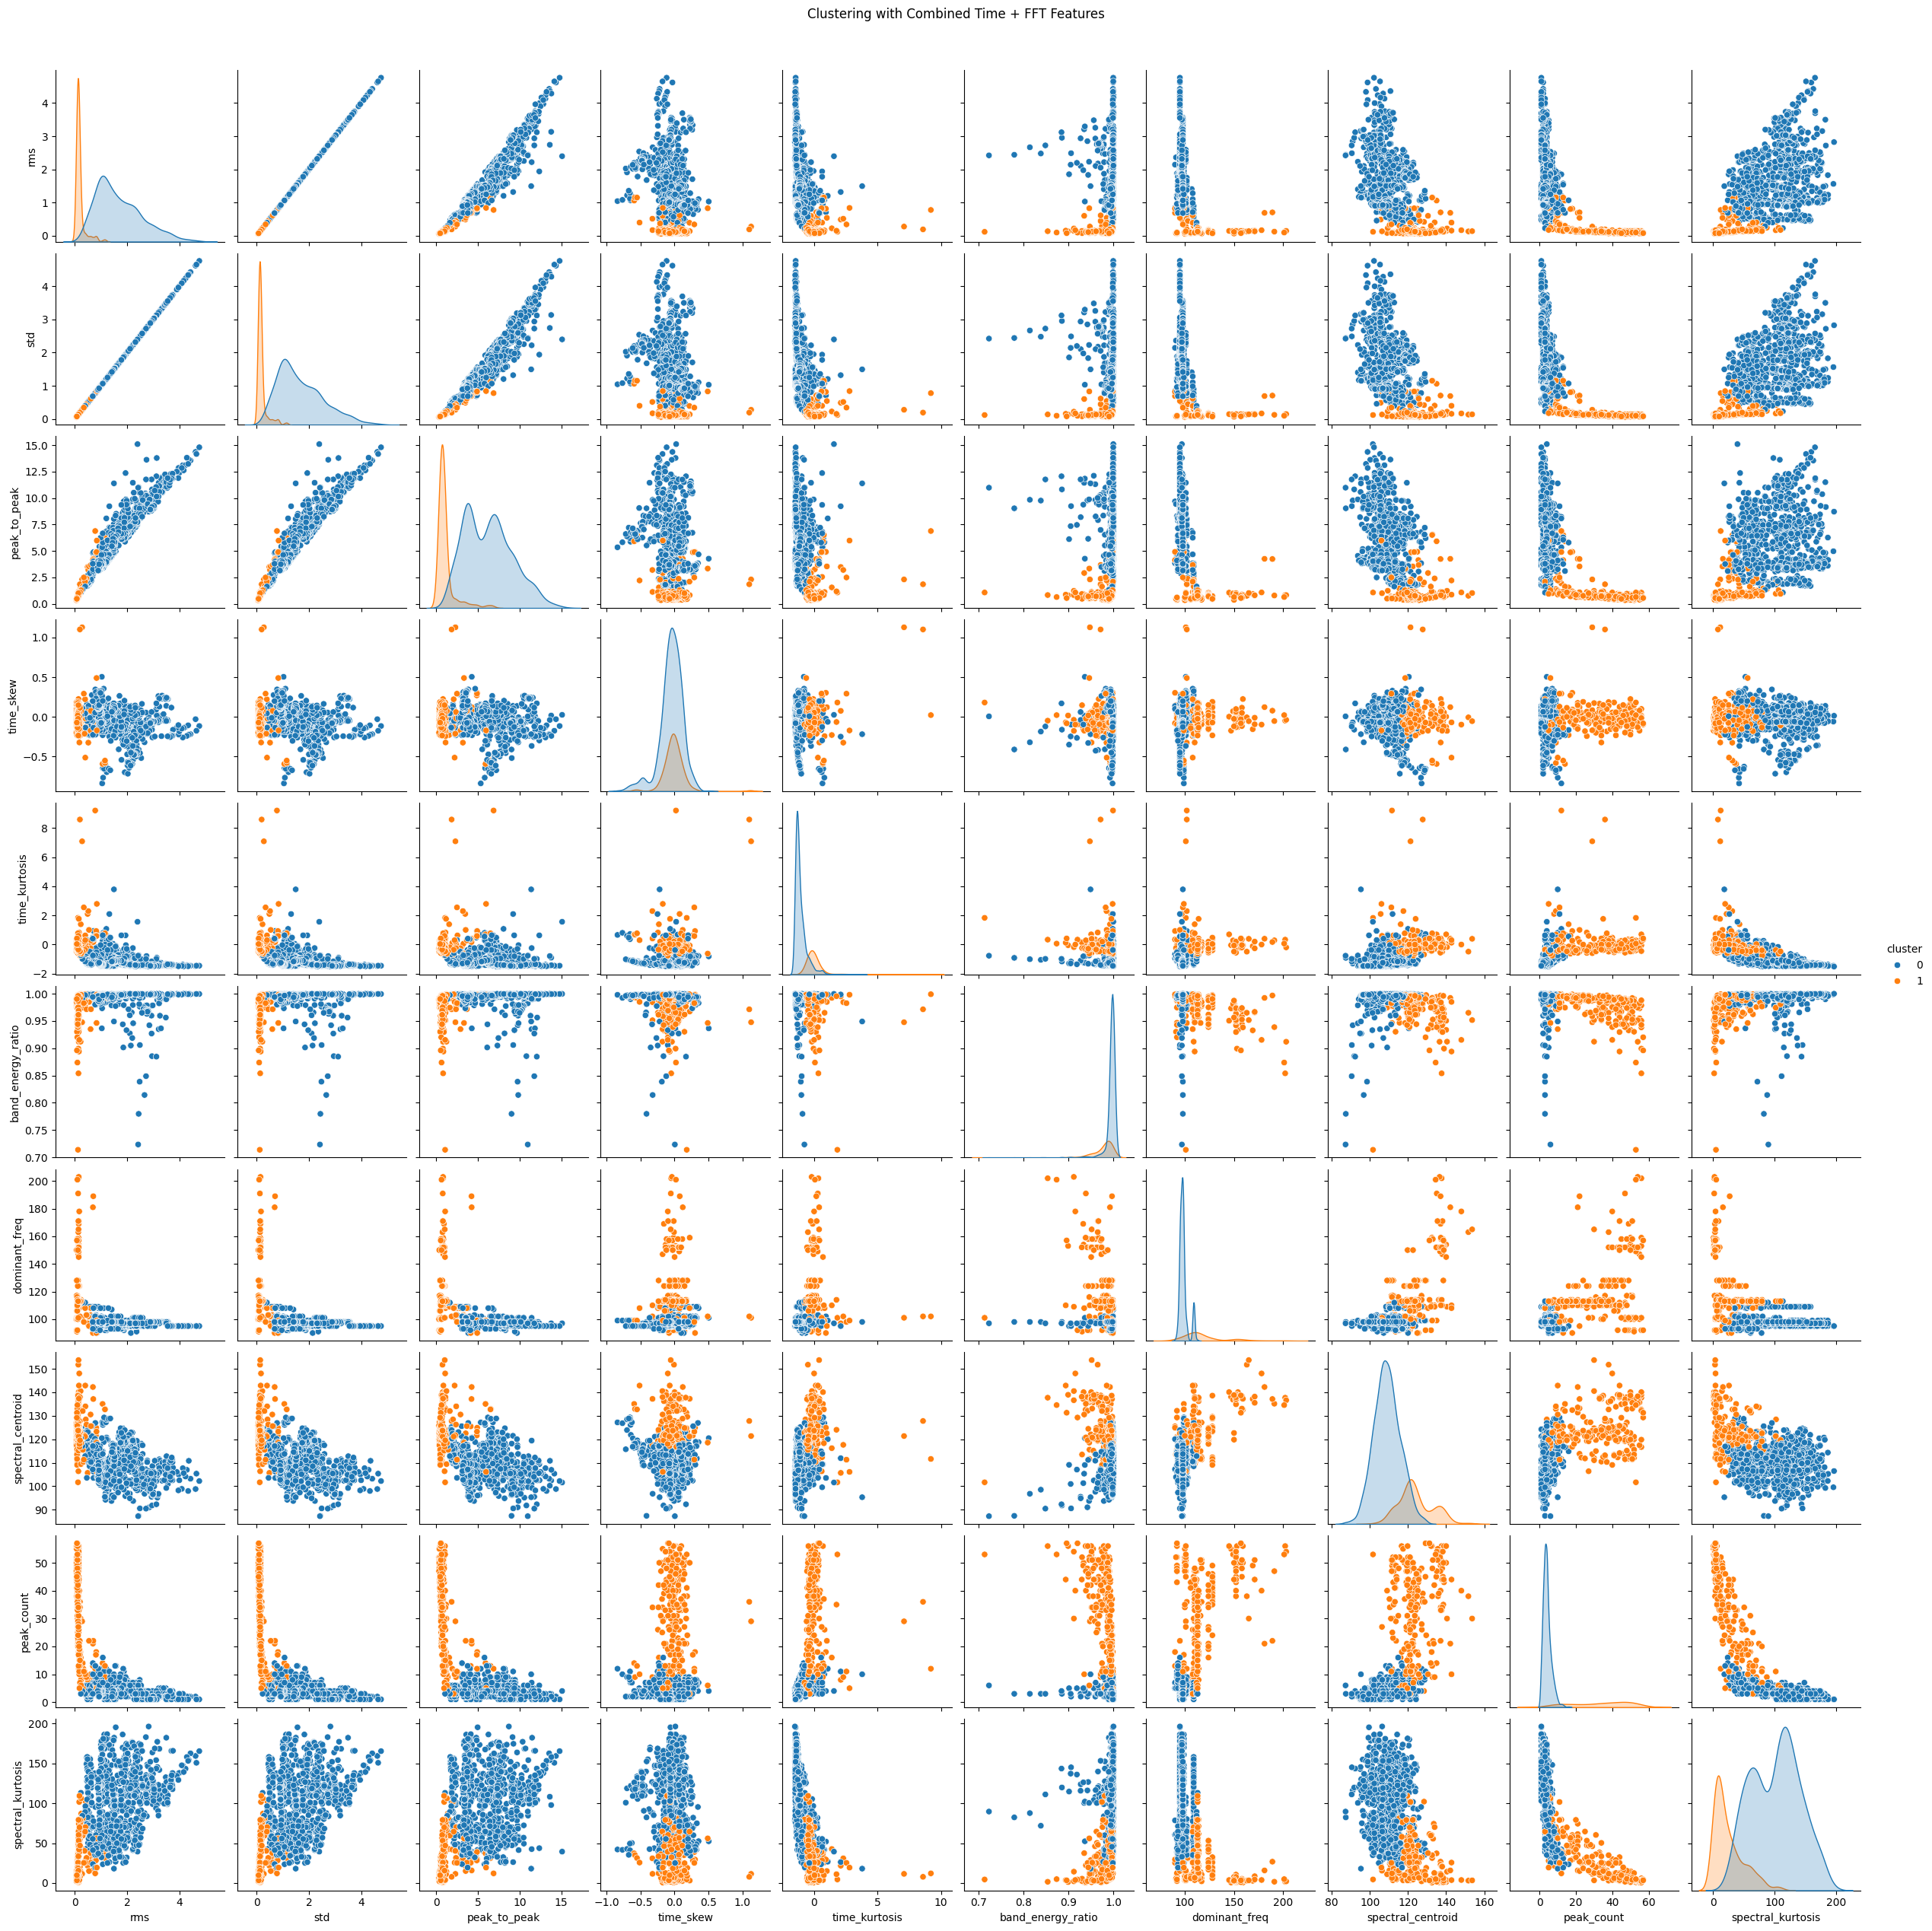

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(combined_df, hue='cluster', diag_kind='kde', vars=feature_cols[:5] + feature_cols[5:])
plt.suptitle("Clustering with Combined Time + FFT Features", y=1.02)
plt.show()


In [23]:
def plot_time_and_fft(signal, sampling_rate, title_prefix="Signal", show=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Time-domain
    time_axis = np.linspace(0, len(signal) / sampling_rate, len(signal))
    axs[0].plot(time_axis, signal)
    axs[0].set_title(f"{title_prefix} - Time Domain")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")

    # Frequency-domain
    freqs = rfftfreq(len(signal), d=1/sampling_rate)
    fft_vals = np.abs(rfft(signal))
    axs[1].plot(freqs, fft_vals)
    axs[1].set_title(f"{title_prefix} - FFT")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Amplitude")

    plt.tight_layout()
    if show:
        plt.show()


In [19]:
combined_df['key'] = combined_df['file'] + '_' + combined_df['start_time'].astype(str) + '_' + combined_df['axis']
windows_df['key'] = windows_df['file'] + '_' + windows_df['start_time'].astype(str)
windows_dict = windows_df.set_index('key').to_dict('index')



🎯 Cluster 1 - Representative Samples
🔹 Axis: X


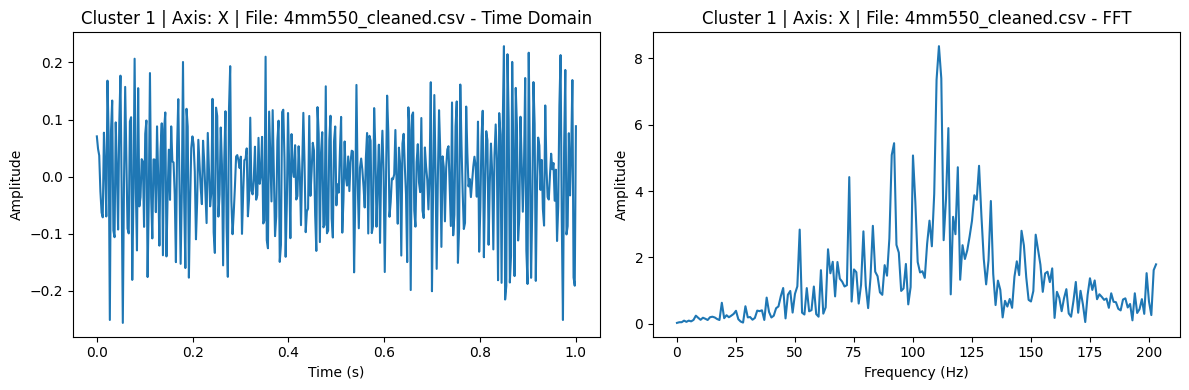

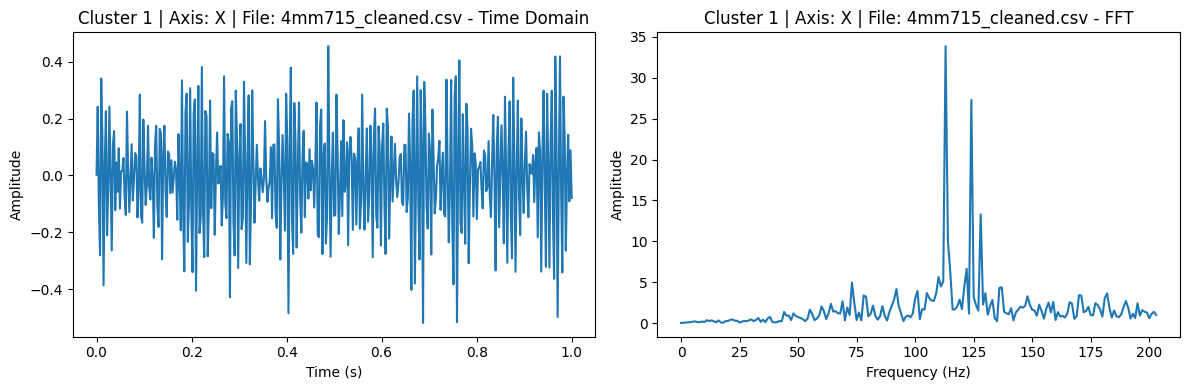

🔹 Axis: Y


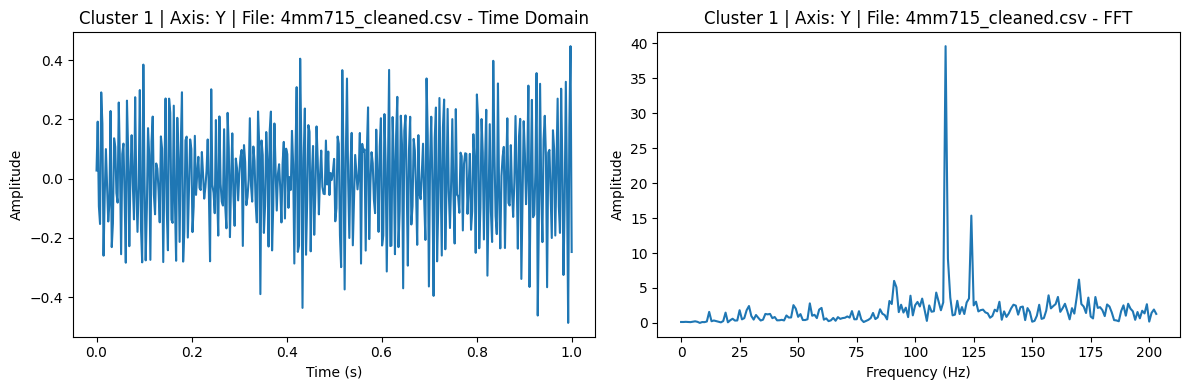

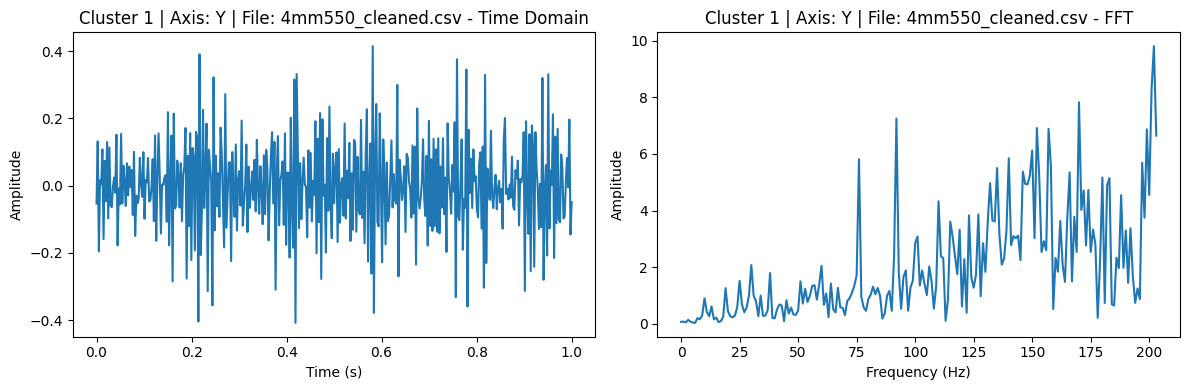

🔹 Axis: Z


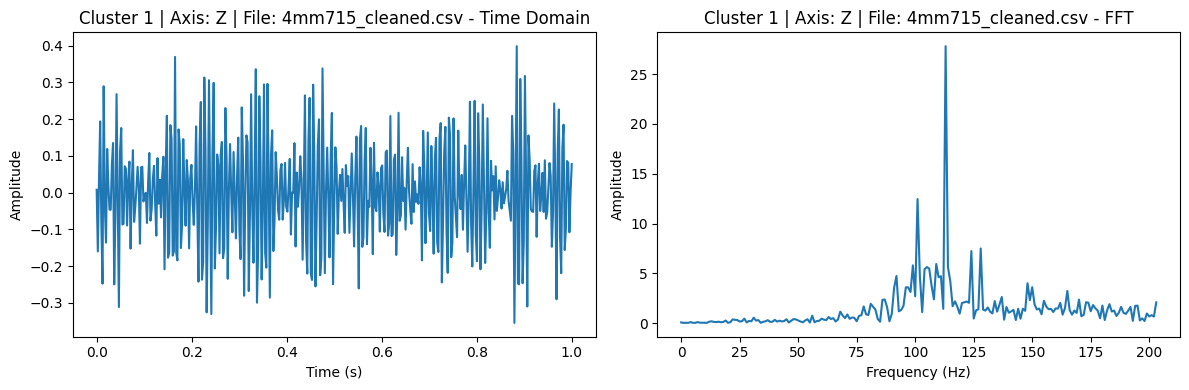

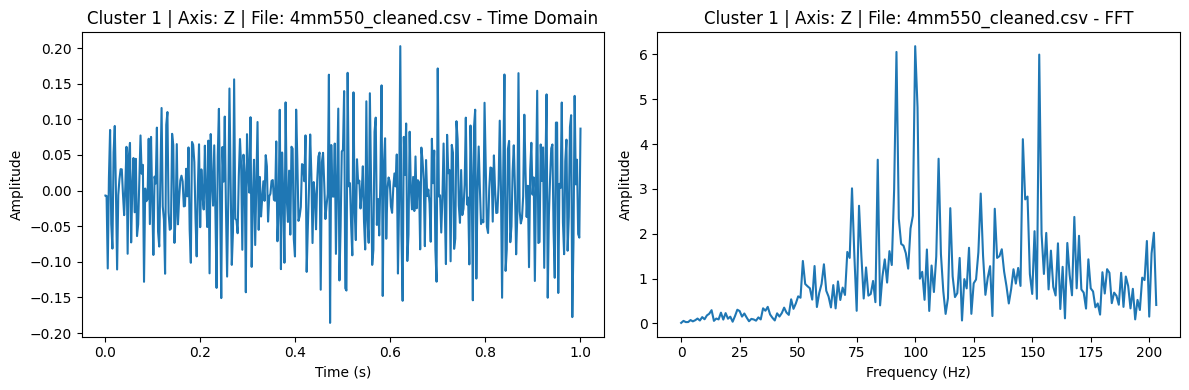


🎯 Cluster 0 - Representative Samples
🔹 Axis: X


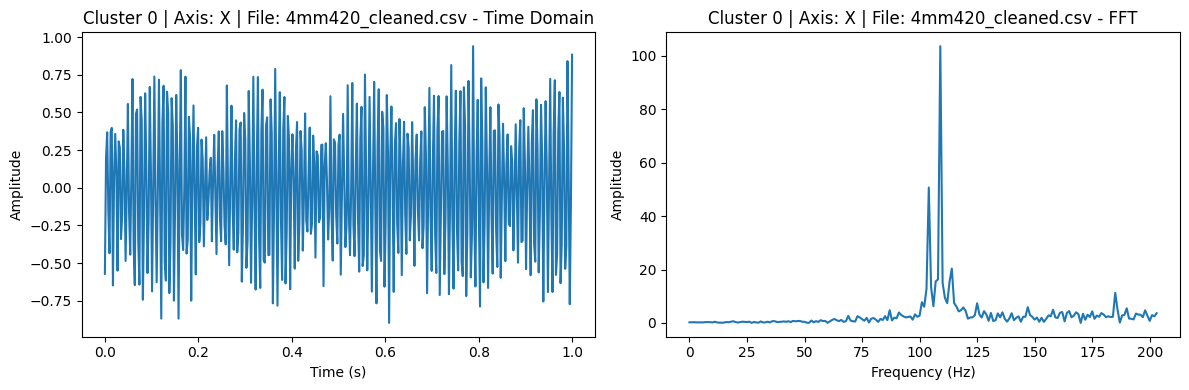

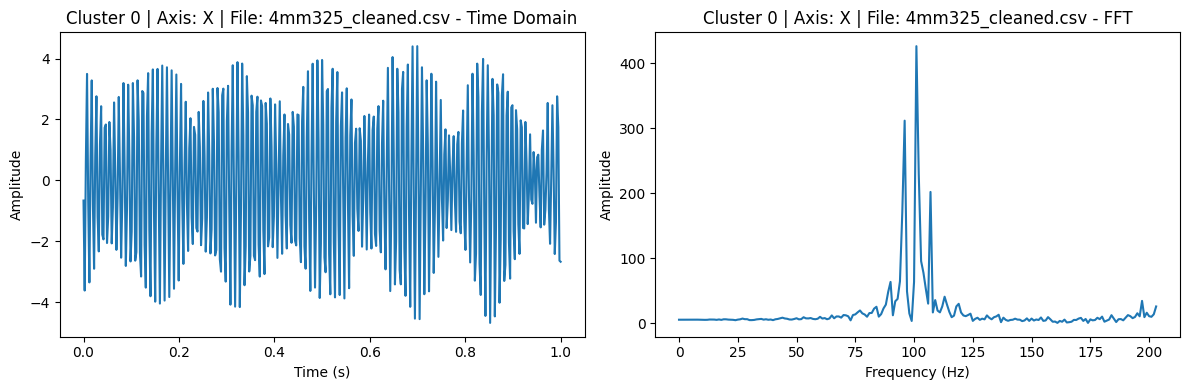

🔹 Axis: Y


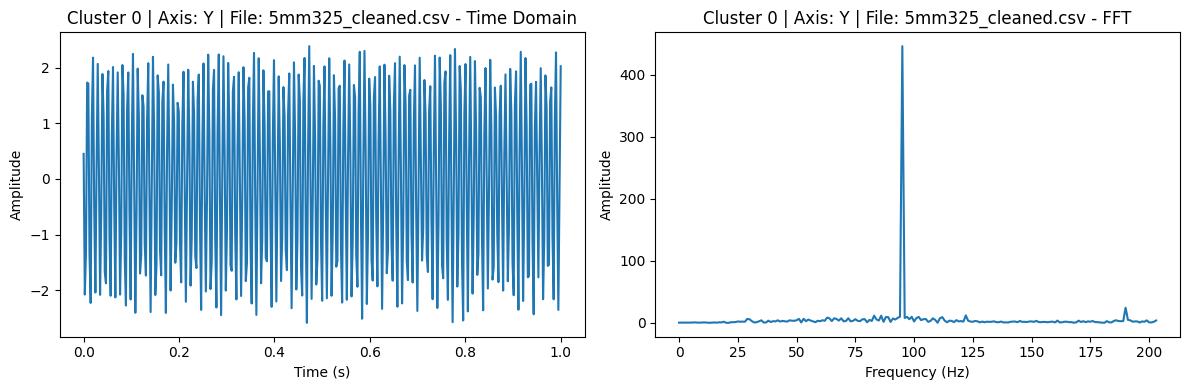

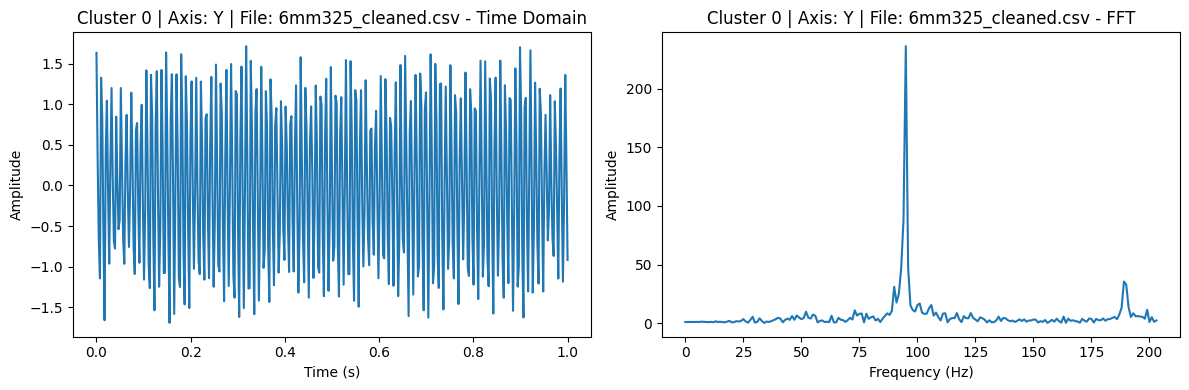

🔹 Axis: Z


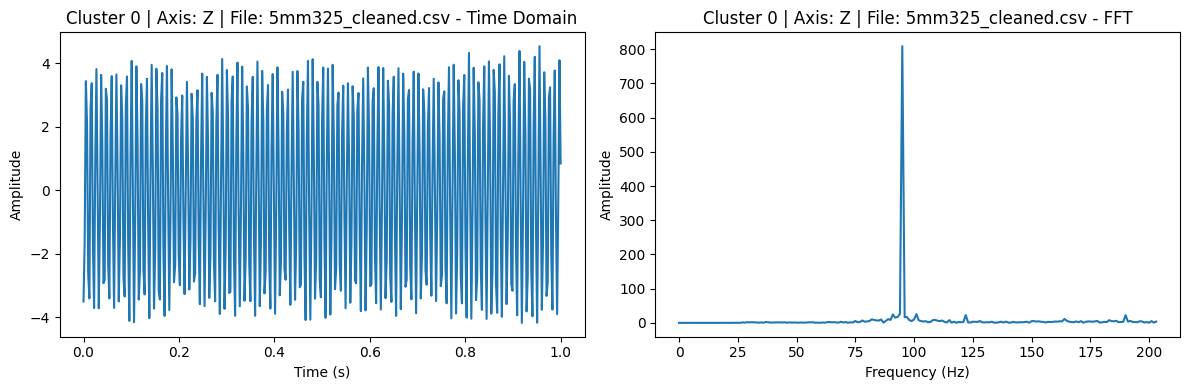

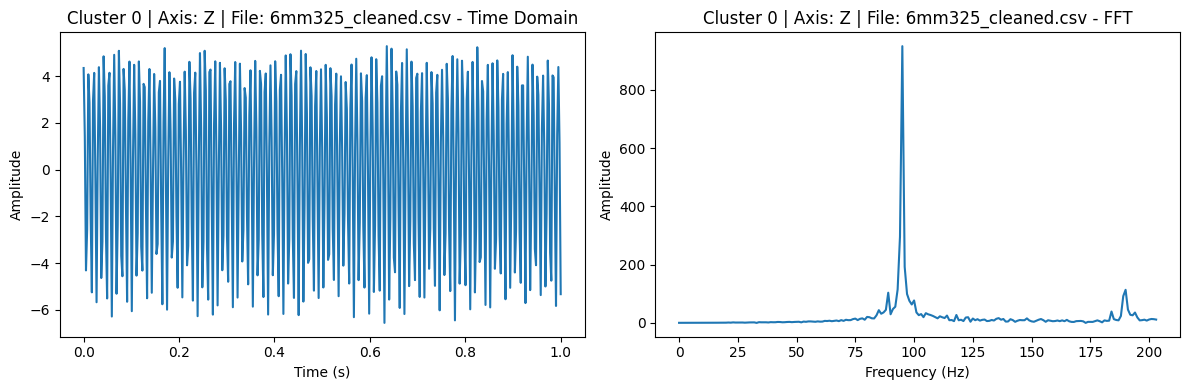

In [24]:
for cluster_id in combined_df['cluster'].unique():
    print(f"\n🎯 Cluster {cluster_id} - Representative Samples")

    for axis in ['X', 'Y', 'Z']:
        print(f"🔹 Axis: {axis}")

        cluster_data = combined_df[(combined_df['cluster'] == cluster_id) & (combined_df['axis'] == axis)]

        # Skip if no samples
        if cluster_data.empty:
            continue

        samples = cluster_data.sample(n=min(2, len(cluster_data)), random_state=42)

        for _, row in samples.iterrows():
            window_key = row['file'] + '_' + str(row['start_time'])
            segment_data = windows_dict.get(window_key)

            if segment_data:
                signal = segment_data[axis]
                sr = segment_data['sampling_rate']

                title = f"Cluster {cluster_id} | Axis: {axis} | File: {row['file']}"
                plot_time_and_fft(signal, sr, title_prefix=title)


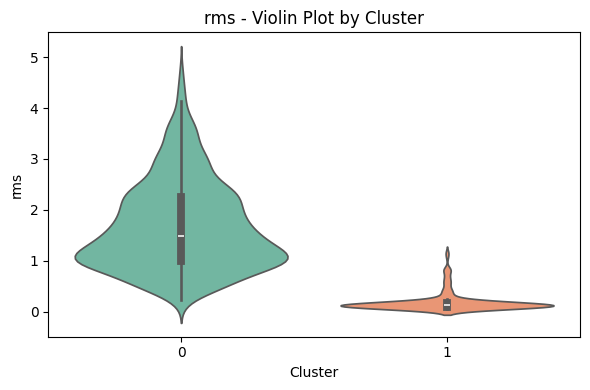

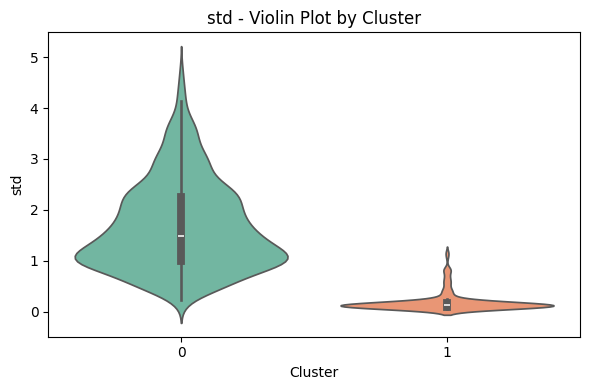

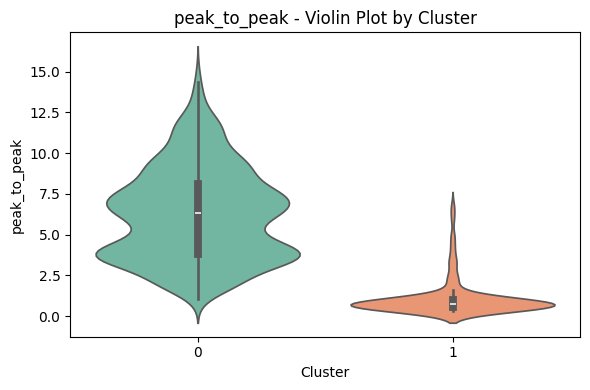

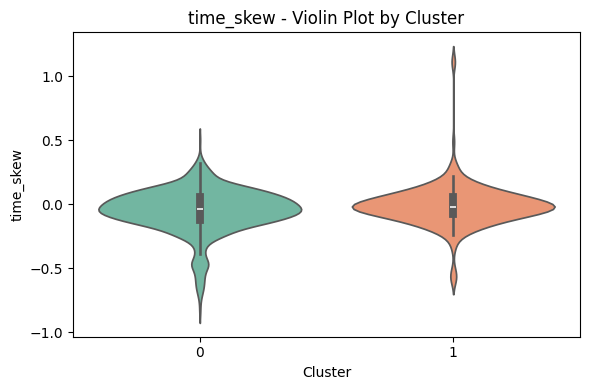

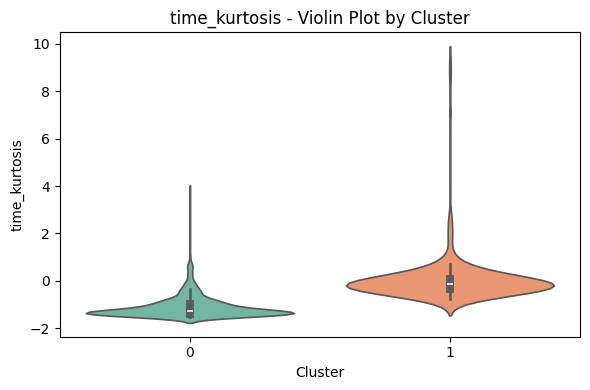

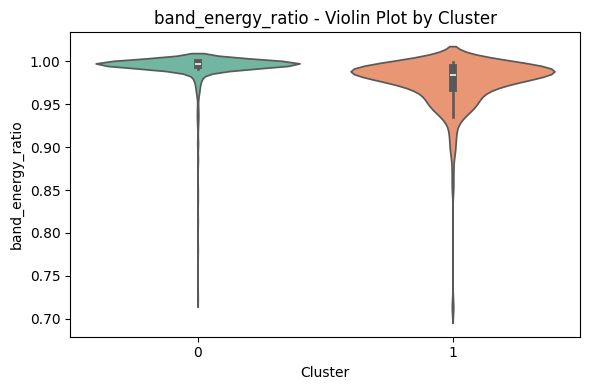

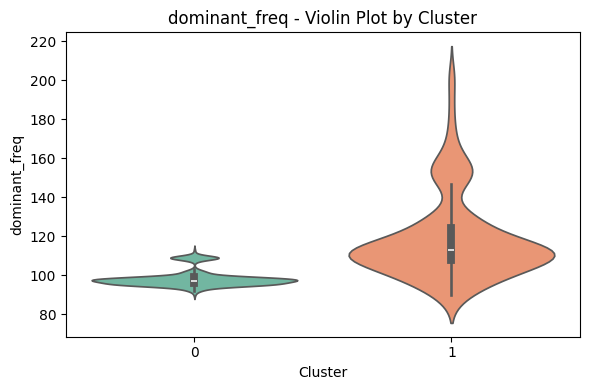

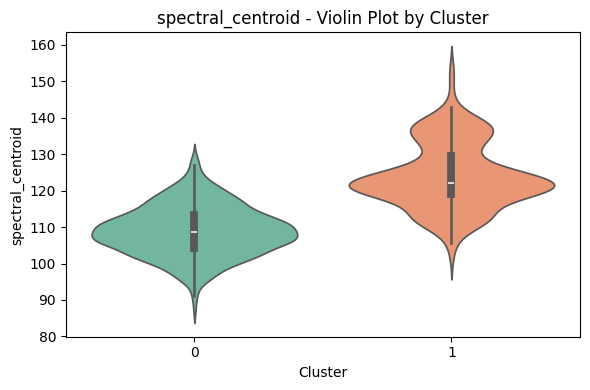

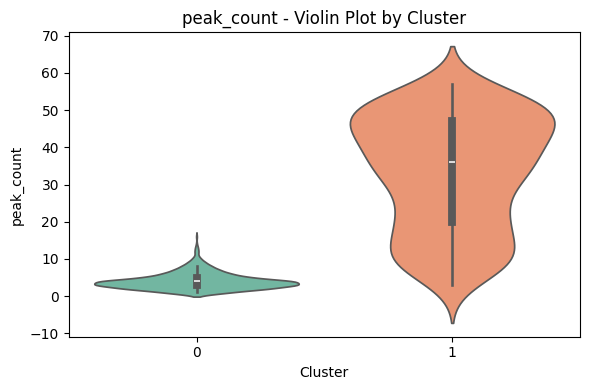

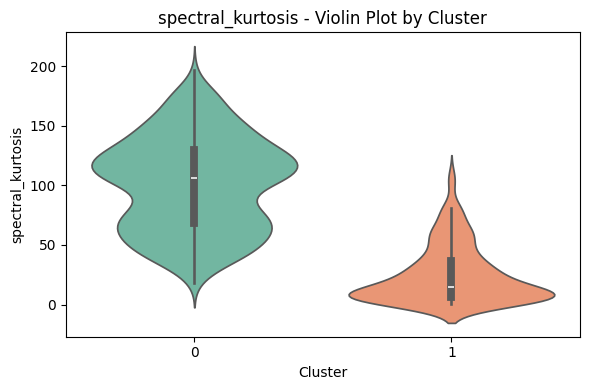

In [25]:
for feature in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=combined_df, x='cluster', y=feature,hue = 'cluster', palette='Set2', inner='box',legend=False)
    plt.title(f"{feature} - Violin Plot by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


In [26]:
# 1 = chatter, 0 = stable
cluster_to_label = {
    0: 0,  # cluster 0 → stable
    1: 1   # cluster 1 → chatter
}

combined_df['chatter_label'] = combined_df['cluster'].map(cluster_to_label)



🔍 Sample Stable Segments


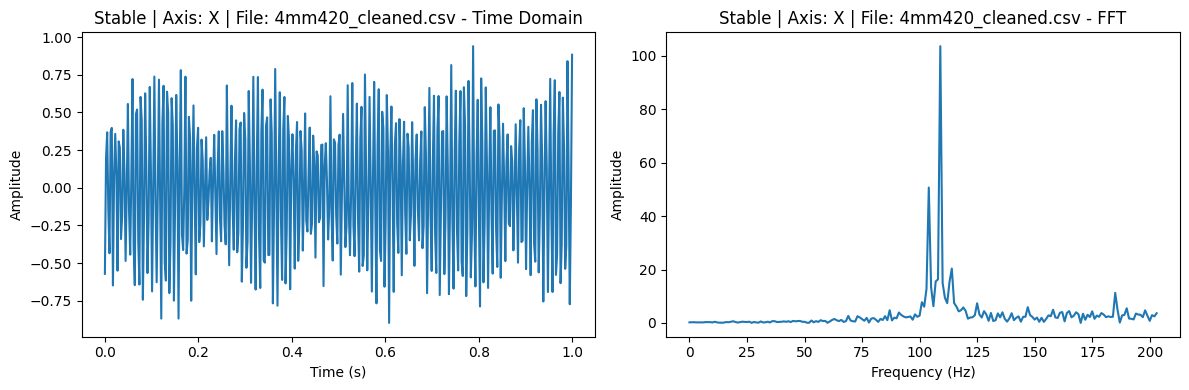

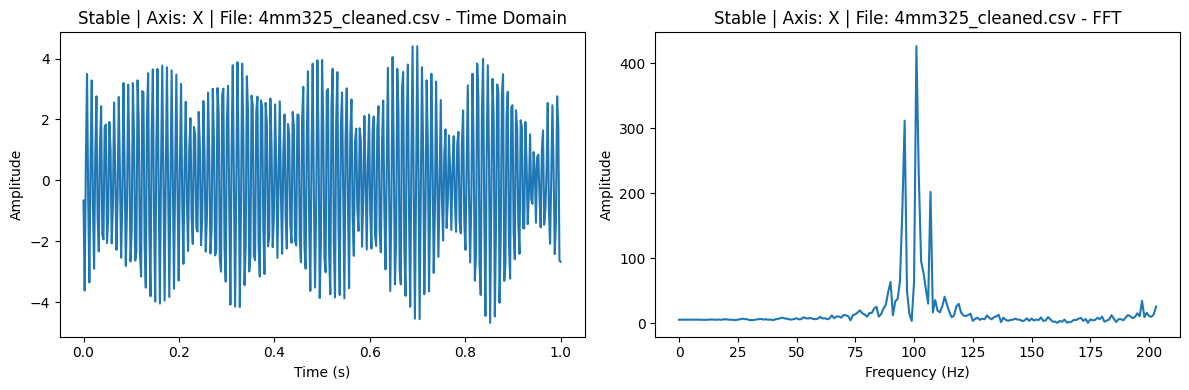

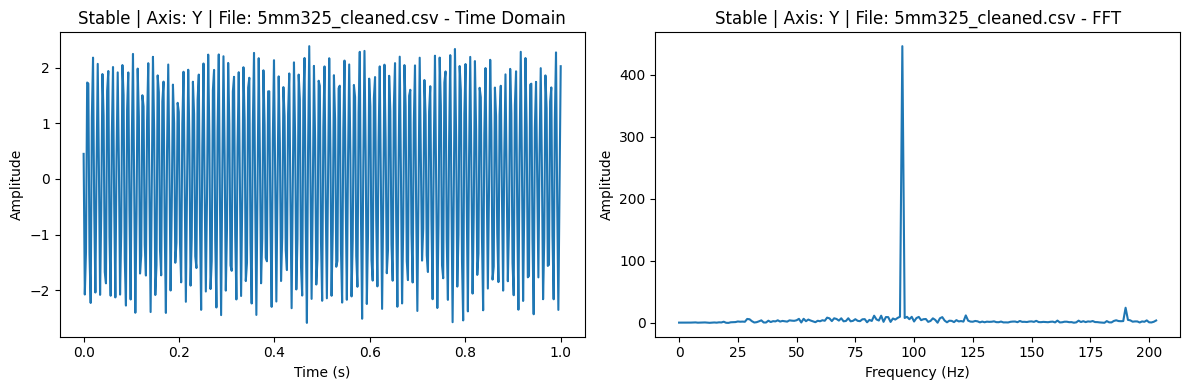

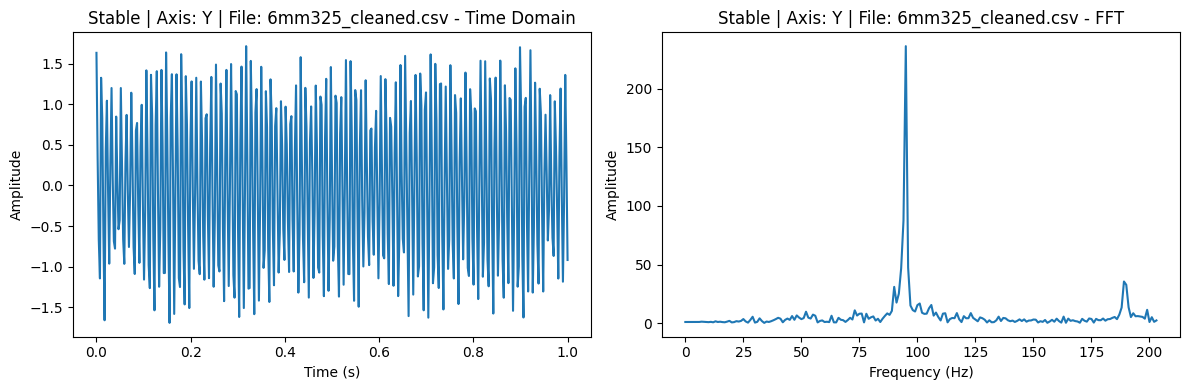

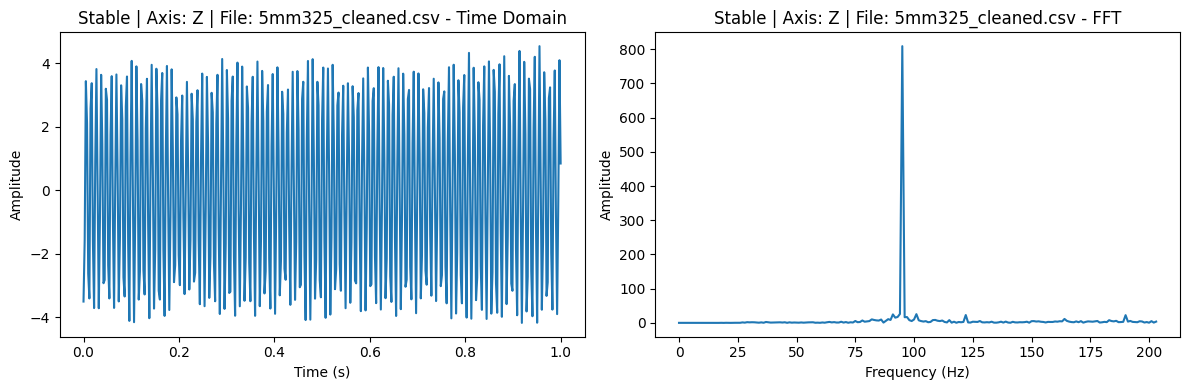

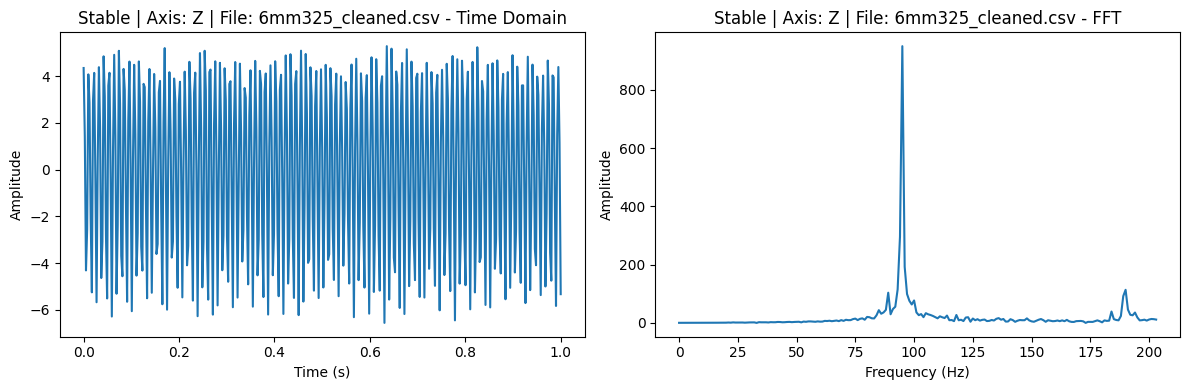


🔍 Sample Chatter Segments


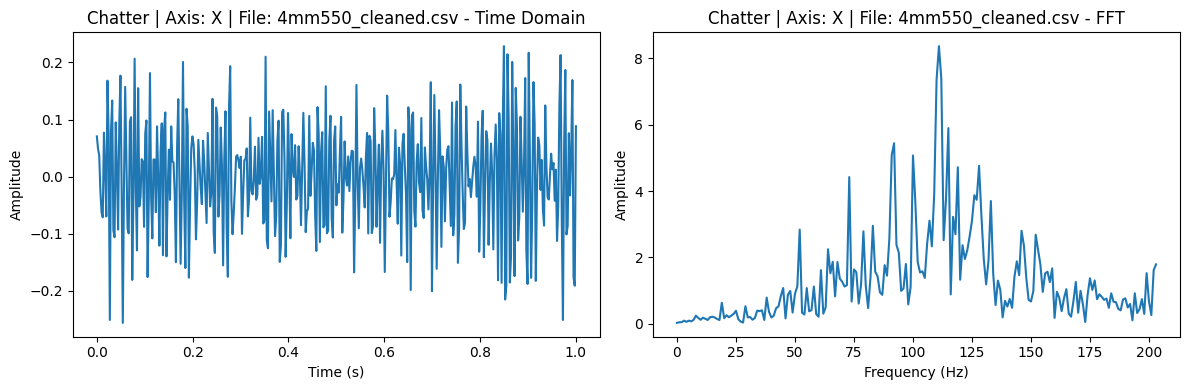

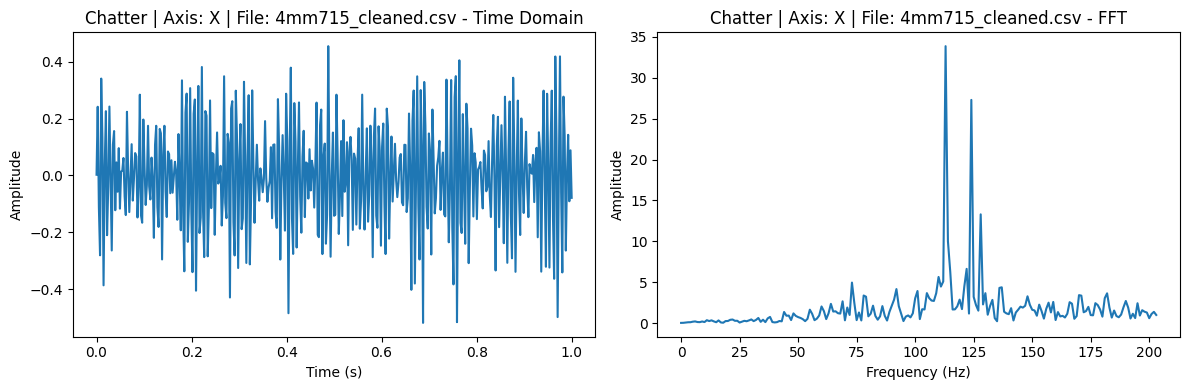

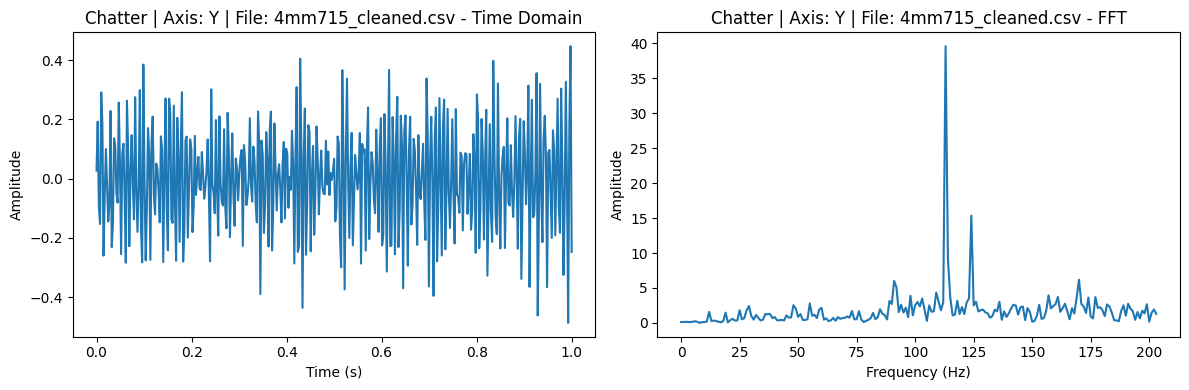

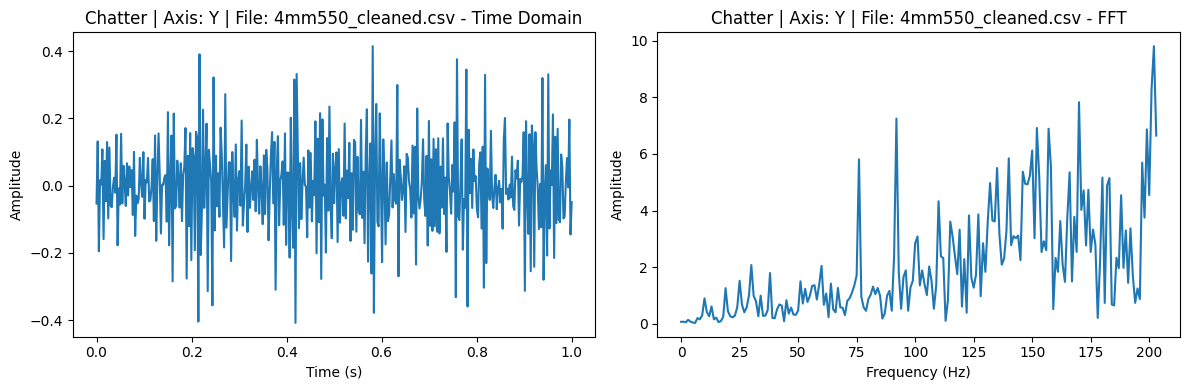

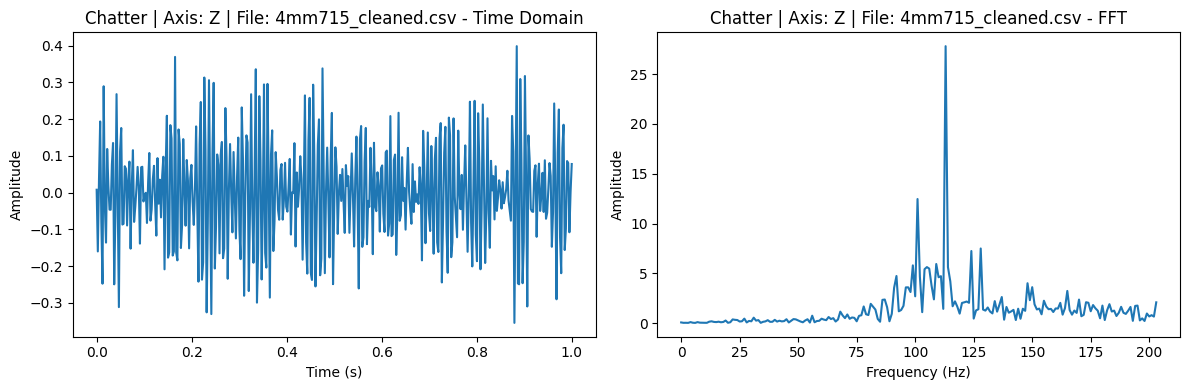

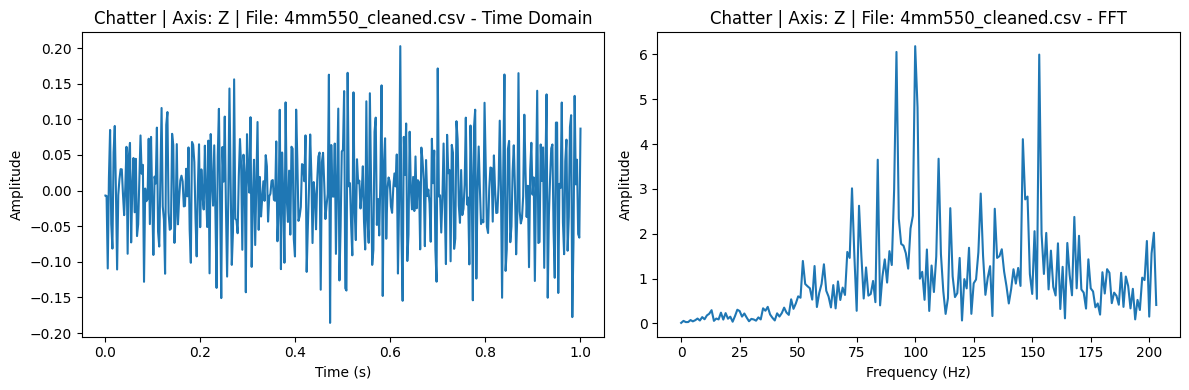

In [27]:
# Plot some chatter vs stable samples
for label in [0, 1]:
    label_name = 'Chatter' if label == 1 else 'Stable'
    print(f"\n🔍 Sample {label_name} Segments")

    for axis in ['X', 'Y', 'Z']:
        samples = combined_df[(combined_df['chatter_label'] == label) & (combined_df['axis'] == axis)].sample(2, random_state=42)

        for _, row in samples.iterrows():
            key = row['file'] + '_' + str(row['start_time'])
            signal = windows_dict.get(key, {}).get(axis)
            sr = windows_dict.get(key, {}).get('sampling_rate')
            if signal is not None:
                title = f"{label_name} | Axis: {axis} | File: {row['file']}"
                plot_time_and_fft(signal, sr, title_prefix=title)


In [28]:
# Optional: Save to CSV for future supervised training
combined_df.to_csv("labeled_segments.csv", index=False)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

features = [
    'rms', 'std', 'peak_to_peak', 'time_skew', 'time_kurtosis',
    'band_energy_ratio', 'dominant_freq', 'spectral_centroid',
    'peak_count', 'spectral_kurtosis'
]

# Already done earlier:
# features = [...]
X = combined_df[features]
y = combined_df['chatter_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



🔧 Training: Random Forest

 Random Forest Accuracy: 0.9867
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       176
           1       1.00      0.94      0.97        50

    accuracy                           0.99       226
   macro avg       0.99      0.97      0.98       226
weighted avg       0.99      0.99      0.99       226



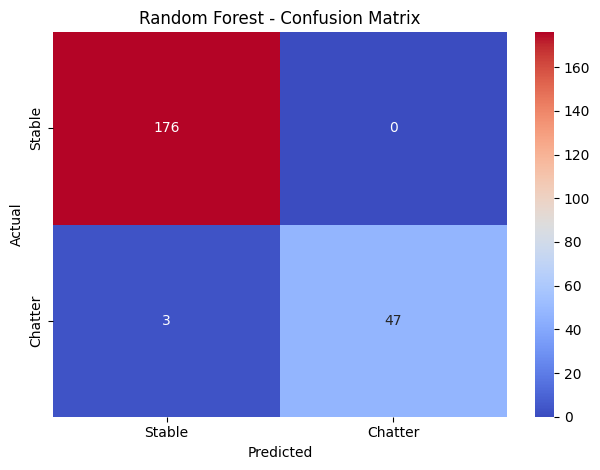


🔧 Training: SVM

 SVM Accuracy: 0.9469
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       176
           1       1.00      0.76      0.86        50

    accuracy                           0.95       226
   macro avg       0.97      0.88      0.92       226
weighted avg       0.95      0.95      0.94       226



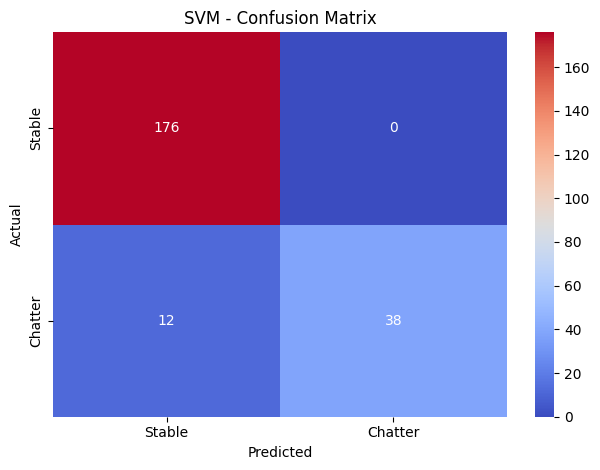


🔧 Training: KNN

 KNN Accuracy: 0.9690
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       176
           1       1.00      0.86      0.92        50

    accuracy                           0.97       226
   macro avg       0.98      0.93      0.95       226
weighted avg       0.97      0.97      0.97       226



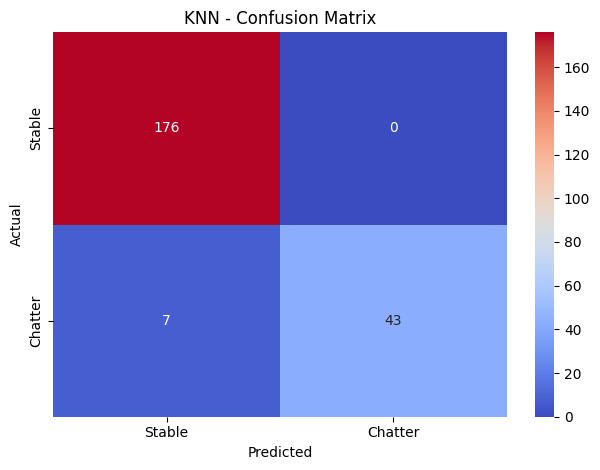


🔧 Training: XGBoost

 XGBoost Accuracy: 0.9912
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       176
           1       1.00      0.96      0.98        50

    accuracy                           0.99       226
   macro avg       0.99      0.98      0.99       226
weighted avg       0.99      0.99      0.99       226



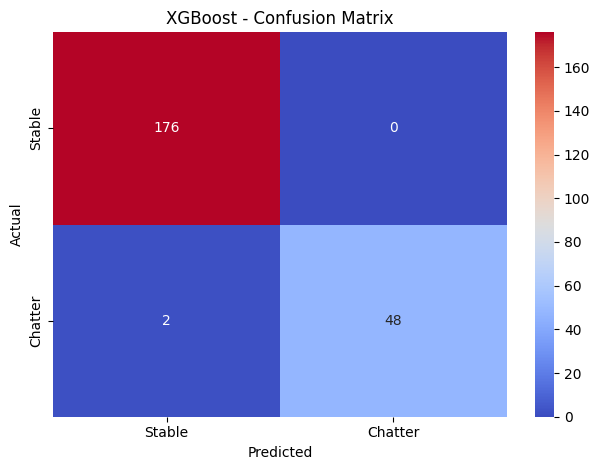

In [32]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {"accuracy": acc, "report": report}

    # Print readable output
    print(f"\n {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=['Stable', 'Chatter'],
                yticklabels=['Stable', 'Chatter'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [35]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier( eval_metric='logloss', random_state=42)
}

cv_results = {}

for name, model in models.items():
    print(f"\n Cross-validating: {name}")
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    cv_results[name] = scores

    print(f" Mean Accuracy: {scores.mean():.4f}")
    print(f" Std Deviation: {scores.std():.4f}")



 Cross-validating: Random Forest
 Mean Accuracy: 0.9929
 Std Deviation: 0.0060

 Cross-validating: SVM
 Mean Accuracy: 0.9619
 Std Deviation: 0.0045

 Cross-validating: KNN
 Mean Accuracy: 0.9778
 Std Deviation: 0.0062

 Cross-validating: XGBoost
 Mean Accuracy: 0.9911
 Std Deviation: 0.0048


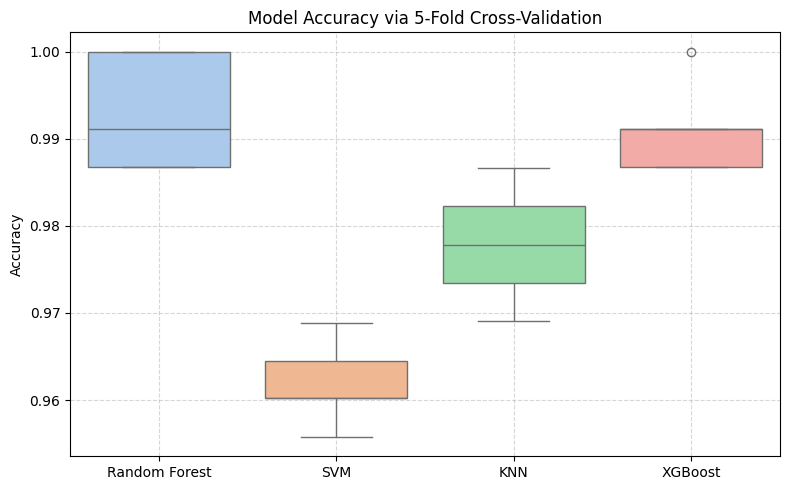

In [36]:
# Boxplot of CV scores
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(8, 5))
sns.boxplot(data=cv_df, palette='pastel')
plt.title("Model Accuracy via 5-Fold Cross-Validation")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [37]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_metrics = {}

for name, model in models.items():
    print(f"\n🔄 Cross-validating: {name}")

    scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)

    # Store means for summary
    metrics_summary = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}
    cv_metrics[name] = metrics_summary

    for metric, score in metrics_summary.items():
        print(f"{metric.capitalize():<10}: {score:.4f}")



🔄 Cross-validating: Random Forest
Accuracy  : 0.9929
Precision : 0.9918
Recall    : 0.9758
F1        : 0.9837

🔄 Cross-validating: SVM
Accuracy  : 0.9619
Precision : 1.0000
Recall    : 0.8273
F1        : 0.9054

🔄 Cross-validating: KNN
Accuracy  : 0.9778
Precision : 0.9956
Recall    : 0.9038
F1        : 0.9473

🔄 Cross-validating: XGBoost
Accuracy  : 0.9911
Precision : 0.9840
Recall    : 0.9759
F1        : 0.9798


In [38]:
cv_metrics_df = pd.DataFrame(cv_metrics).T  # transpose for easier viewing
cv_metrics_df = cv_metrics_df.round(4)
display(cv_metrics_df)


accuracy  precision  recall      f1
Random Forest    0.9929     0.9918  0.9758  0.9837
SVM              0.9619     1.0000  0.8273  0.9054
KNN              0.9778     0.9956  0.9038  0.9473
XGBoost          0.9911     0.9840  0.9759  0.9798

In [39]:
from sklearn.model_selection import cross_val_score
roc_auc_scores = {}

for name, model in models.items():
    print(f"\n Evaluating ROC AUC: {name}")
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    roc_auc_scores[name] = scores

    print(f" Mean ROC AUC: {scores.mean():.4f}")
    print(f" Std Deviation: {scores.std():.4f}")



 Evaluating ROC AUC: Random Forest
 Mean ROC AUC: 0.9995
 Std Deviation: 0.0006

 Evaluating ROC AUC: SVM
 Mean ROC AUC: 0.9971
 Std Deviation: 0.0019

 Evaluating ROC AUC: KNN
 Mean ROC AUC: 0.9880
 Std Deviation: 0.0071

 Evaluating ROC AUC: XGBoost
 Mean ROC AUC: 0.9995
 Std Deviation: 0.0004


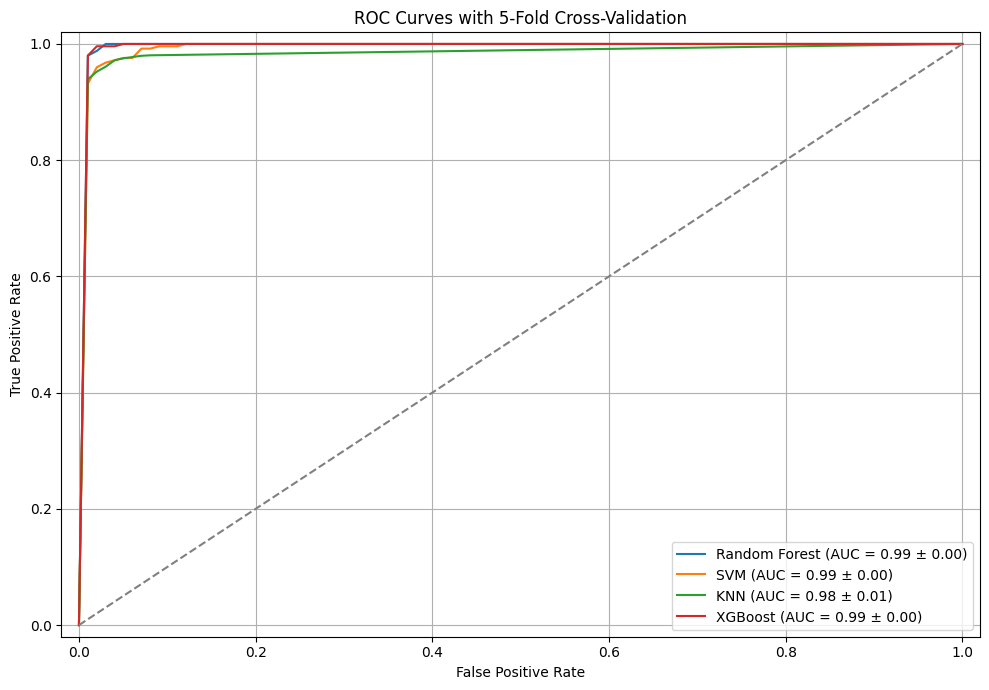

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(models, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    plt.figure(figsize=(10, 7))

    for name, model in models.items():
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train, test in cv.split(X, y):
            m = clone(model)
            m.fit(X.iloc[train], y[train])
            if hasattr(m, "predict_proba"):
                probas_ = m.predict_proba(X.iloc[test])[:, 1]
            else:  # For SVM
                probas_ = m.decision_function(X.iloc[test])
            fpr, tpr, _ = roc_curve(y[test], probas_)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        plt.plot(mean_fpr, mean_tpr,
                 label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves with 5-Fold Cross-Validation')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves(models, X, y, cv_splits=5)

In [41]:
# Calculate mean and std for ROC AUC
roc_auc_mean_std = {
    model: (np.mean(scores), np.std(scores))
    for model, scores in roc_auc_scores.items()
}

# Add to cv_metrics_df
cv_metrics_df['ROC AUC Mean'] = cv_metrics_df.index.map(lambda m: roc_auc_mean_std[m][0])
cv_metrics_df['ROC AUC Std'] = cv_metrics_df.index.map(lambda m: roc_auc_mean_std[m][1])

# Optional: Sort by ROC AUC Mean
cv_metrics_df_sorted = cv_metrics_df.sort_values(by='ROC AUC Mean', ascending=False)

# Round nicely
cv_metrics_df_sorted = cv_metrics_df_sorted.round(4)


In [42]:
from IPython.display import display

print("📋 Final Model Comparison (Cross-Validation Metrics):")
display(cv_metrics_df_sorted)


📋 Final Model Comparison (Cross-Validation Metrics):


accuracy  precision  recall      f1  ROC AUC Mean  ROC AUC Std
XGBoost          0.9911     0.9840  0.9759  0.9798        0.9995       0.0004
Random Forest    0.9929     0.9918  0.9758  0.9837        0.9995       0.0006
SVM              0.9619     1.0000  0.8273  0.9054        0.9971       0.0019
KNN              0.9778     0.9956  0.9038  0.9473        0.9880       0.0071

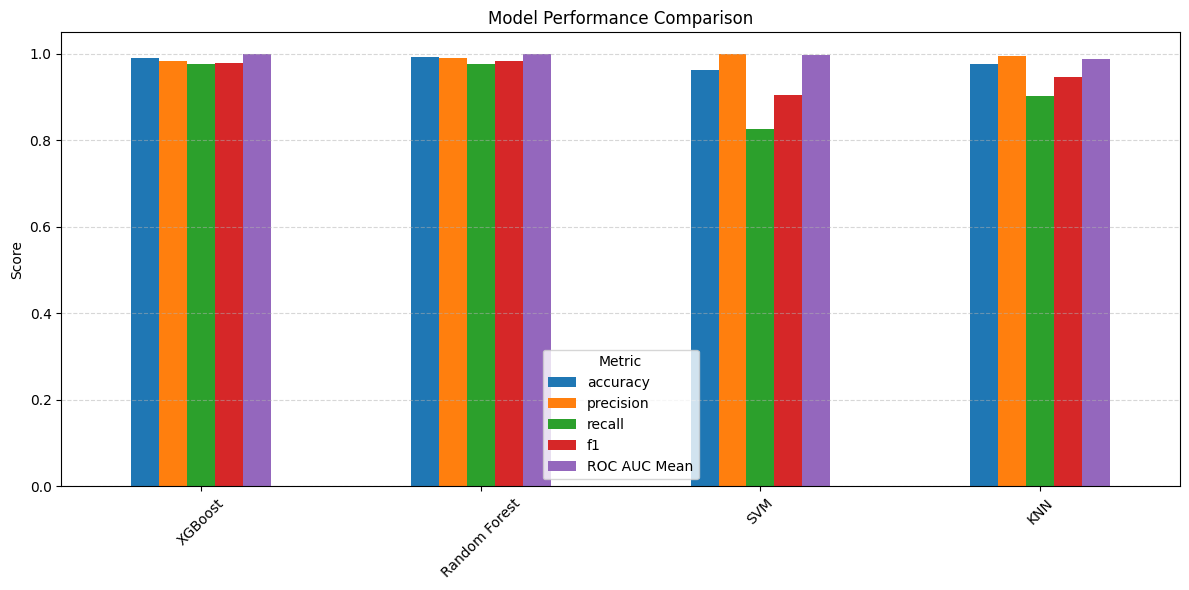

In [42]:
cv_metrics_df_sorted[['accuracy', 'precision', 'recall', 'f1', 'ROC AUC Mean']].plot(
    kind='bar', figsize=(12, 6)
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [44]:
# Import necessary models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
svm_model = SVC(probability=True, random_state=42)
knn_model = KNeighborsClassifier()

# Train models
rf_model.fit(X, y)
xgb_model.fit(X, y)
svm_model.fit(X, y)
knn_model.fit(X, y)


KNeighborsClassifier()

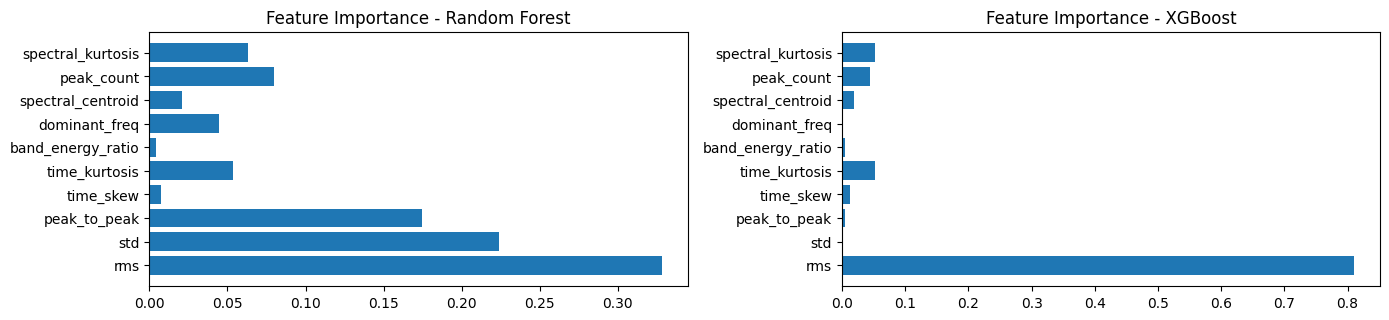

In [45]:
# Random Forest Feature Importance
importances_rf = rf_model.feature_importances_

# XGBoost Feature Importance
importances_xgb = xgb_model.feature_importances_

# Plot feature importances for Random Forest and XGBoost
plt.figure(figsize=(14, 6))

# Random Forest Plot
plt.subplot(2, 2, 1)
plt.barh(X.columns, importances_rf)
plt.title("Feature Importance - Random Forest")

# XGBoost Plot
plt.subplot(2, 2, 2)
plt.barh(X.columns, importances_xgb)
plt.title("Feature Importance - XGBoost")

plt.tight_layout()
plt.show()


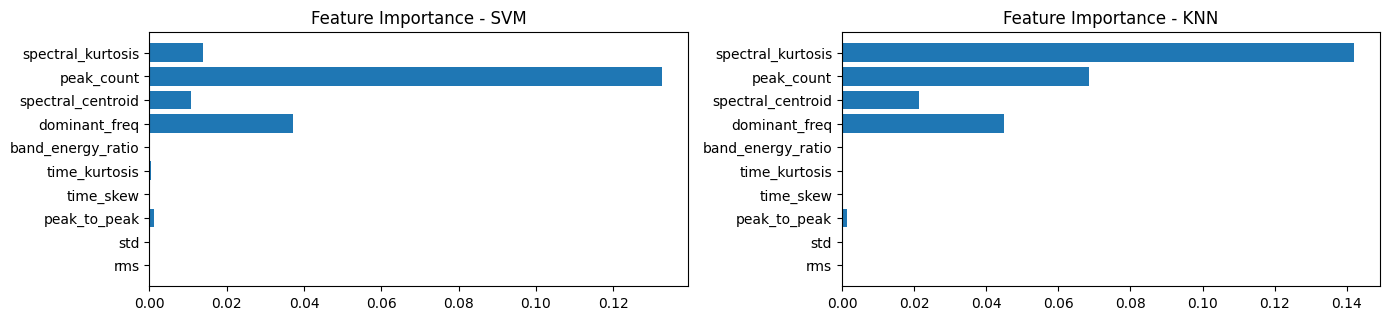

In [46]:
from sklearn.inspection import permutation_importance

# SVM Permutation Importance
result_svm = permutation_importance(svm_model, X, y, n_repeats=10, random_state=42)

# KNN Permutation Importance
result_knn = permutation_importance(knn_model, X, y, n_repeats=10, random_state=42)

# Plot feature importances for SVM and KNN
plt.figure(figsize=(14, 6))

# SVM Plot
plt.subplot(2, 2, 3)
plt.barh(X.columns, result_svm.importances_mean)
plt.title("Feature Importance - SVM")

# KNN Plot
plt.subplot(2, 2, 4)
plt.barh(X.columns, result_knn.importances_mean)
plt.title("Feature Importance - KNN")

plt.tight_layout()
plt.show()


In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Define base models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
svm_model = SVC(probability=True, random_state=42)
knn_model = KNeighborsClassifier()

# Create a Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('svm', svm_model),
        ('knn', knn_model)
    ],
    voting='soft'  # Use 'soft' for probability-based (average of predicted probabilities)
)

# Train the Voting Classifier
voting_model.fit(X, y)

# Evaluate the Voting Classifier
y_pred_voting = voting_model.predict(X)
accuracy_voting = accuracy_score(y, y_pred_voting)
precision_voting = precision_score(y, y_pred_voting)
recall_voting = recall_score(y, y_pred_voting)
f1_voting = f1_score(y, y_pred_voting)
roc_auc_voting = roc_auc_score(y, voting_model.predict_proba(X)[:, 1])

# Results
print("Voting Classifier Performance:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"ROC AUC: {roc_auc_voting:.4f}")


Voting Classifier Performance:
Accuracy: 0.9982
Precision: 1.0000
Recall: 0.9920
F1 Score: 0.9960
ROC AUC: 1.0000


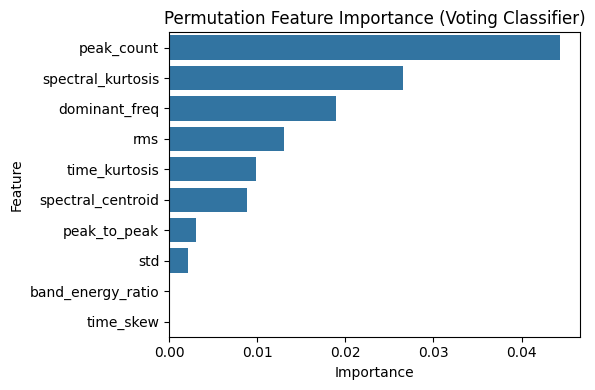

In [48]:
from sklearn.inspection import permutation_importance

result = permutation_importance(voting_model, X, y, n_repeats=10, random_state=42, n_jobs=-1)

# Create DataFrame
perm_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title('Permutation Feature Importance (Voting Classifier)')
plt.tight_layout()
plt.show()


In [49]:
import joblib
joblib.dump(voting_model, 'voting_model.pkl')


['voting_model.pkl']